# MLP from Scratch with Dropout
- Minh Nguyen
- 11/20/2024
- Note
  - We see that Softmax Regression only can only use 1 layer, with MLP we can do multiple layers,
  - Softmax Regression is purely linear
  - Softmax Regression Architecture as "single-layer neural network":
    - Input -> Fully Connected Layer -> Softmax -> Output
  - MLP Architecture
    - Input Layer
    - Hidden Layers with Non-linear
    - Output Layer that has softmax for classification
- Dropout regularize the network and reduce overfitting. Dropout randomly zeroes out a frantion of the neurons during training, forcing the model to learn more robust fatures

Epoch 1/10, Loss: 0.8764
Epoch 2/10, Loss: 0.6295
Epoch 3/10, Loss: 0.5761
Epoch 4/10, Loss: 0.5515
Epoch 5/10, Loss: 0.5339
Epoch 6/10, Loss: 0.5189
Epoch 7/10, Loss: 0.5028
Epoch 8/10, Loss: 0.4982
Epoch 9/10, Loss: 0.4882
Epoch 10/10, Loss: 0.4827
Test Accuracy: 0.8473


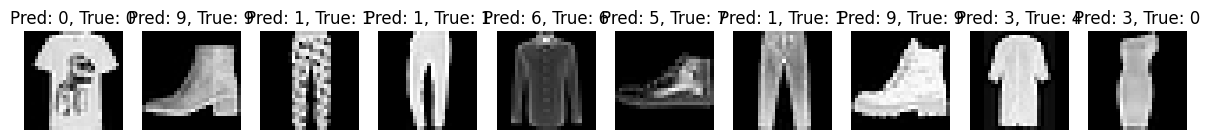

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load and preprocess dataset
batch_size = 256
num_epochs = 10
learning_rate = 0.1

# Normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# Download and load the datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP model with Dropout
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  # Flatten input from (N, 1, 28, 28) to (N, 784)
        self.hidden_layer = nn.Linear(input_size, hidden_size)  # Hidden Layer
        self.activation = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer
        self.output_layer = nn.Linear(hidden_size, output_size)  # Output Layer
    
    def forward(self, X):
        X = self.flatten(X)
        X = self.hidden_layer(X)
        X = self.activation(X)  # Apply activation
        X = self.dropout(X)  # Apply dropout
        logits = self.output_layer(X)
        return logits

# Initialize model, loss, and optimizer
num_inputs = 28 * 28
num_outputs = 10
hidden_size = 50
dropout_rate = 0.5

model = MLP(num_inputs, hidden_size, num_outputs, dropout_rate)
loss_fn = nn.CrossEntropyLoss()  # Combine softmax activation and cross-entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train function
def train(model, train_loader, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set to training mode (enables dropout)
        total_loss, total_samples = 0, 0
        
        for X, y in train_loader:   
            # Forward pass
            logits = model(X)
            loss = loss_fn(logits, y)
            
            # Backward pass
            optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update parameters
            
            # Track loss
            total_loss += loss.item() * X.size(0)
            total_samples += X.size(0)
    
        avg_loss = total_loss / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluate function
def evaluate(model, test_loader):
    model.eval()  # Set to evaluation mode (disables dropout)
    correct, total = 0, 0
    
    with torch.no_grad():  # Disable gradient computation
        for X, y in test_loader:
            logits = model(X)
            predictions = logits.argmax(dim=1)  # Get the class with the highest score
            correct += (predictions == y).sum().item()
            total += y.size(0)
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Train the model
train(model, train_loader, loss_fn, optimizer, num_epochs)

# Evaluate the model
evaluate(model, test_loader)

# Visualize predictions
def visualize_predictions(model, dataset, num_samples=10):
    model.eval()
    indices = torch.randperm(len(dataset))[:num_samples]  # Randomly select samples
    samples = torch.stack([dataset[i][0] for i in indices])  # Images
    labels = [dataset[i][1] for i in indices]  # True labels

    with torch.no_grad():
        logits = model(samples)
        predictions = logits.argmax(dim=1)  # Predicted labels

    # Plot images with predicted and true labels
    plt.figure(figsize=(15, 5))
    for i, (img, pred, true) in enumerate(zip(samples, predictions, labels)):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Pred: {pred.item()}, True: {true}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset)
